In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

from matplotlib import rc
from statsmodels.stats.multicomp import MultiComparison
from tools import *

%matplotlib inline
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_context('notebook')

In [2]:
def load_data(files):
    import json
    rv = list()
    for filename in files:
        with open(filename, 'r') as infile:
            rv += json.load(infile)

    # clean up data to fit assumptions
    EPS = 1e-9
    for entry in rv:
        entry['auc'] = sum(entry['accuracy'])
        entry['final_accuracy'] = entry['accuracy'][-1]
        entry['lambda_'] = entry['lambda']  # pandas doesn't allow for columns to be called lambda
        del entry['lambda']
        if entry['approximator'] == 'constant':
            entry['optimizer'] = 'constant'  # rest of plotting relies on optimizer being defined
        if (entry['optimizer'] == 'sgd') and (abs(float(entry['momentum'])) > EPS):
            entry['optimizer'] = 'momentum'  # separate sgd with and without momentum

    to_delete = list()
    constant_seeds = set()
    for i in range(len(rv)):
        if rv[i]['approximator'] == 'constant':
            if rv[i]['env_seed'] in constant_seeds:
                to_delete.append(i)
            else:
                constant_seeds.add(rv[i]['env_seed'])
    for i in reversed(to_delete):
        del rv[i]

    # return cleaned data
    return rv

def get_summary(data):
    temp = dict()
    for entry in data:
        key = get_hyperparameter_key(entry)
        if key in temp:
            temp[key]['auc'].append(entry['auc'])
            temp[key]['mean_accuracy'].append(np.mean(entry['accuracy']))
            temp[key]['final_accuracy'].append(entry['final_accuracy'])
            if key.optimizer != 'constant':
                temp[key]['mean_activation_overlap'].append(np.mean(entry['activation_overlap']))
                temp[key]['mean_pairwise_interference'].append(np.mean(entry['pairwise_interference']))
        else:
            value = dict()
            value['auc'] = [entry['auc']]
            value['mean_accuracy'] = [np.mean(entry['accuracy'])]
            value['final_accuracy'] = [entry['final_accuracy']]
            if key.optimizer != 'constant':
                value['mean_activation_overlap'] = [np.mean(entry['activation_overlap'])]
                value['mean_pairwise_interference'] = [np.mean(entry['pairwise_interference'])]
            temp[key] = value
    table = list()
    for key1, value in temp.items():
        entry = dict(key1._asdict())
        entry['count'] = len(value['auc'])
        for key2 in ['auc', 'mean_accuracy', 'final_accuracy', 'mean_activation_overlap', 'mean_pairwise_interference']:
            try:
                entry['{}_mean'.format(key2)] = np.mean(value[key2])
                entry['{}_stderr'.format(key2)] = np.std(value[key2]) / np.sqrt(len(value[key2]))
            except KeyError:
                entry['{}_mean'.format(key2)] = np.nan
                entry['{}_stderr'.format(key2)] = np.nan
        table.append(entry)
    return pd.DataFrame(list_of_dicts_to_dict_of_lists(table))

def get_best(data, metric, summary=None):
    if summary is None:
        summary = get_summary(data)
    assert(metric in ['auc', 'final_accuracy'])

    # build best table
    best = list()
    for optimizer in summary['optimizer'].unique():
        sub_table = summary[summary['optimizer'] == optimizer]
        best.append((sub_table.loc[sub_table['{}_mean'.format(metric)].idxmin()]).to_dict())
    return pd.DataFrame(list_of_dicts_to_dict_of_lists(best))

def get_best_by_optimizer(data, best_auc_table=None):
    if best_auc_table is None:
        best_auc_table = get_best_auc_table(data, get_auc_table(data))

    # build best by optimizer dict
    best_keys = {row['optimizer']: get_hyperparameter_key(row.to_dict()) for _, row in best_auc_table.iterrows()}
    rv = dict()
    for entry in data:
        optimizer = entry['optimizer']
        if get_hyperparameter_key(entry) == best_keys[optimizer]:
            if optimizer not in rv:
                rv[optimizer] = [entry]
            else:
                rv[optimizer].append(entry)
    return rv

def get_best_by_optimizer_summary(data, best_auc_table=None, best_by_optimizer=None):
    if best_auc_table is None:
        best_auc_table = get_best_auc_table(data, get_auc_table(data))
    if best_by_optimizer is None:
        best_by_optimizer = get_best_by_optimizer(data, best_auc_table)

    # build best by optimizer summary dict
    rv = {row['optimizer']: row.to_dict() for _, row in best_auc_table.iterrows()}
    for key1 in rv.keys():
        for key2 in result_labels:
            try:
                values = np.array([item[key2] for item in best_by_optimizer[key1]])
                rv[key1][key2 + '_mean'] = np.mean(values, axis=0)
                rv[key1][key2 + '_stderr'] = np.std(values, axis=0) / np.sqrt(values.shape[0])
            except TypeError:
                pass
    return rv

optimizer_nice_names = {'constant': 'Constant', 'adam': 'Adam', 'momentum': 'Momentum', 'rms': 'RMSProp', 'sgd': 'SGD'}

# Experiment 2 Train

In [3]:
data = load_data(['experiment_2_mountain_car_train.json'])
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,...,auc_mean,auc_stderr,mean_accuracy_mean,mean_accuracy_stderr,final_accuracy_mean,final_accuracy_stderr,mean_activation_overlap_mean,mean_activation_overlap_stderr,mean_pairwise_interference_mean,mean_pairwise_interference_stderr
0,neural_network,NaN,NaN,None,TD,0.000086,0.9,momentum,NaN,1.0,...,26177.700019,57.419942,52.250898,0.114611,50.042992,1.326646,0.615356,0.006627,0.972180,0.000334
1,neural_network,NaN,NaN,None,TD,0.000043,NaN,rms,0.99,1.0,...,24541.927570,18.275734,48.985883,0.036479,49.554611,0.380479,0.418061,0.003342,0.967114,0.000499
2,neural_network,NaN,NaN,None,TD,0.000977,0.0,sgd,NaN,1.0,...,27217.845445,115.067067,54.327037,0.229675,55.411684,2.067479,0.659975,0.019246,0.972624,0.000487
3,neural_network,0.9,0.999,None,TD,0.000043,NaN,adam,NaN,1.0,...,24480.093428,20.290186,48.862462,0.040499,51.707445,0.268024,0.438412,0.003689,0.960607,0.000633
4,constant,NaN,NaN,None,None,NaN,NaN,constant,NaN,NaN,...,19725.857983,3.167172,39.372970,0.006322,39.268651,0.002872,NaN,NaN,NaN,NaN


## Momentum Sensitivity

In [4]:
data = load_data(['experiment_2_mountain_car_train.json'])
to_delete = list()
for i, entry in enumerate(data):
    if entry['optimizer'] != 'momentum':
        to_delete.append(i)
    else:
        entry['optimizer'] = entry['momentum']
for i in reversed(to_delete):
    del data[i]
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,...,auc_mean,auc_stderr,mean_accuracy_mean,mean_accuracy_stderr,final_accuracy_mean,final_accuracy_stderr,mean_activation_overlap_mean,mean_activation_overlap_stderr,mean_pairwise_interference_mean,mean_pairwise_interference_stderr
0,neural_network,None,None,None,TD,0.000173,0.81,0.81,None,1,...,26401.845721,65.825919,52.698295,0.131389,51.011252,1.504389,0.647855,0.007753,0.972269,0.000397
1,neural_network,None,None,None,TD,0.000005,0.99,0.99,None,1,...,27881.986834,118.096950,55.652668,0.235722,52.706087,1.914126,0.594954,0.008883,0.972978,0.000511
2,neural_network,None,None,None,TD,0.000086,0.90,0.90,None,1,...,26177.700019,57.419942,52.250898,0.114611,50.042992,1.326646,0.615356,0.006627,0.972180,0.000334


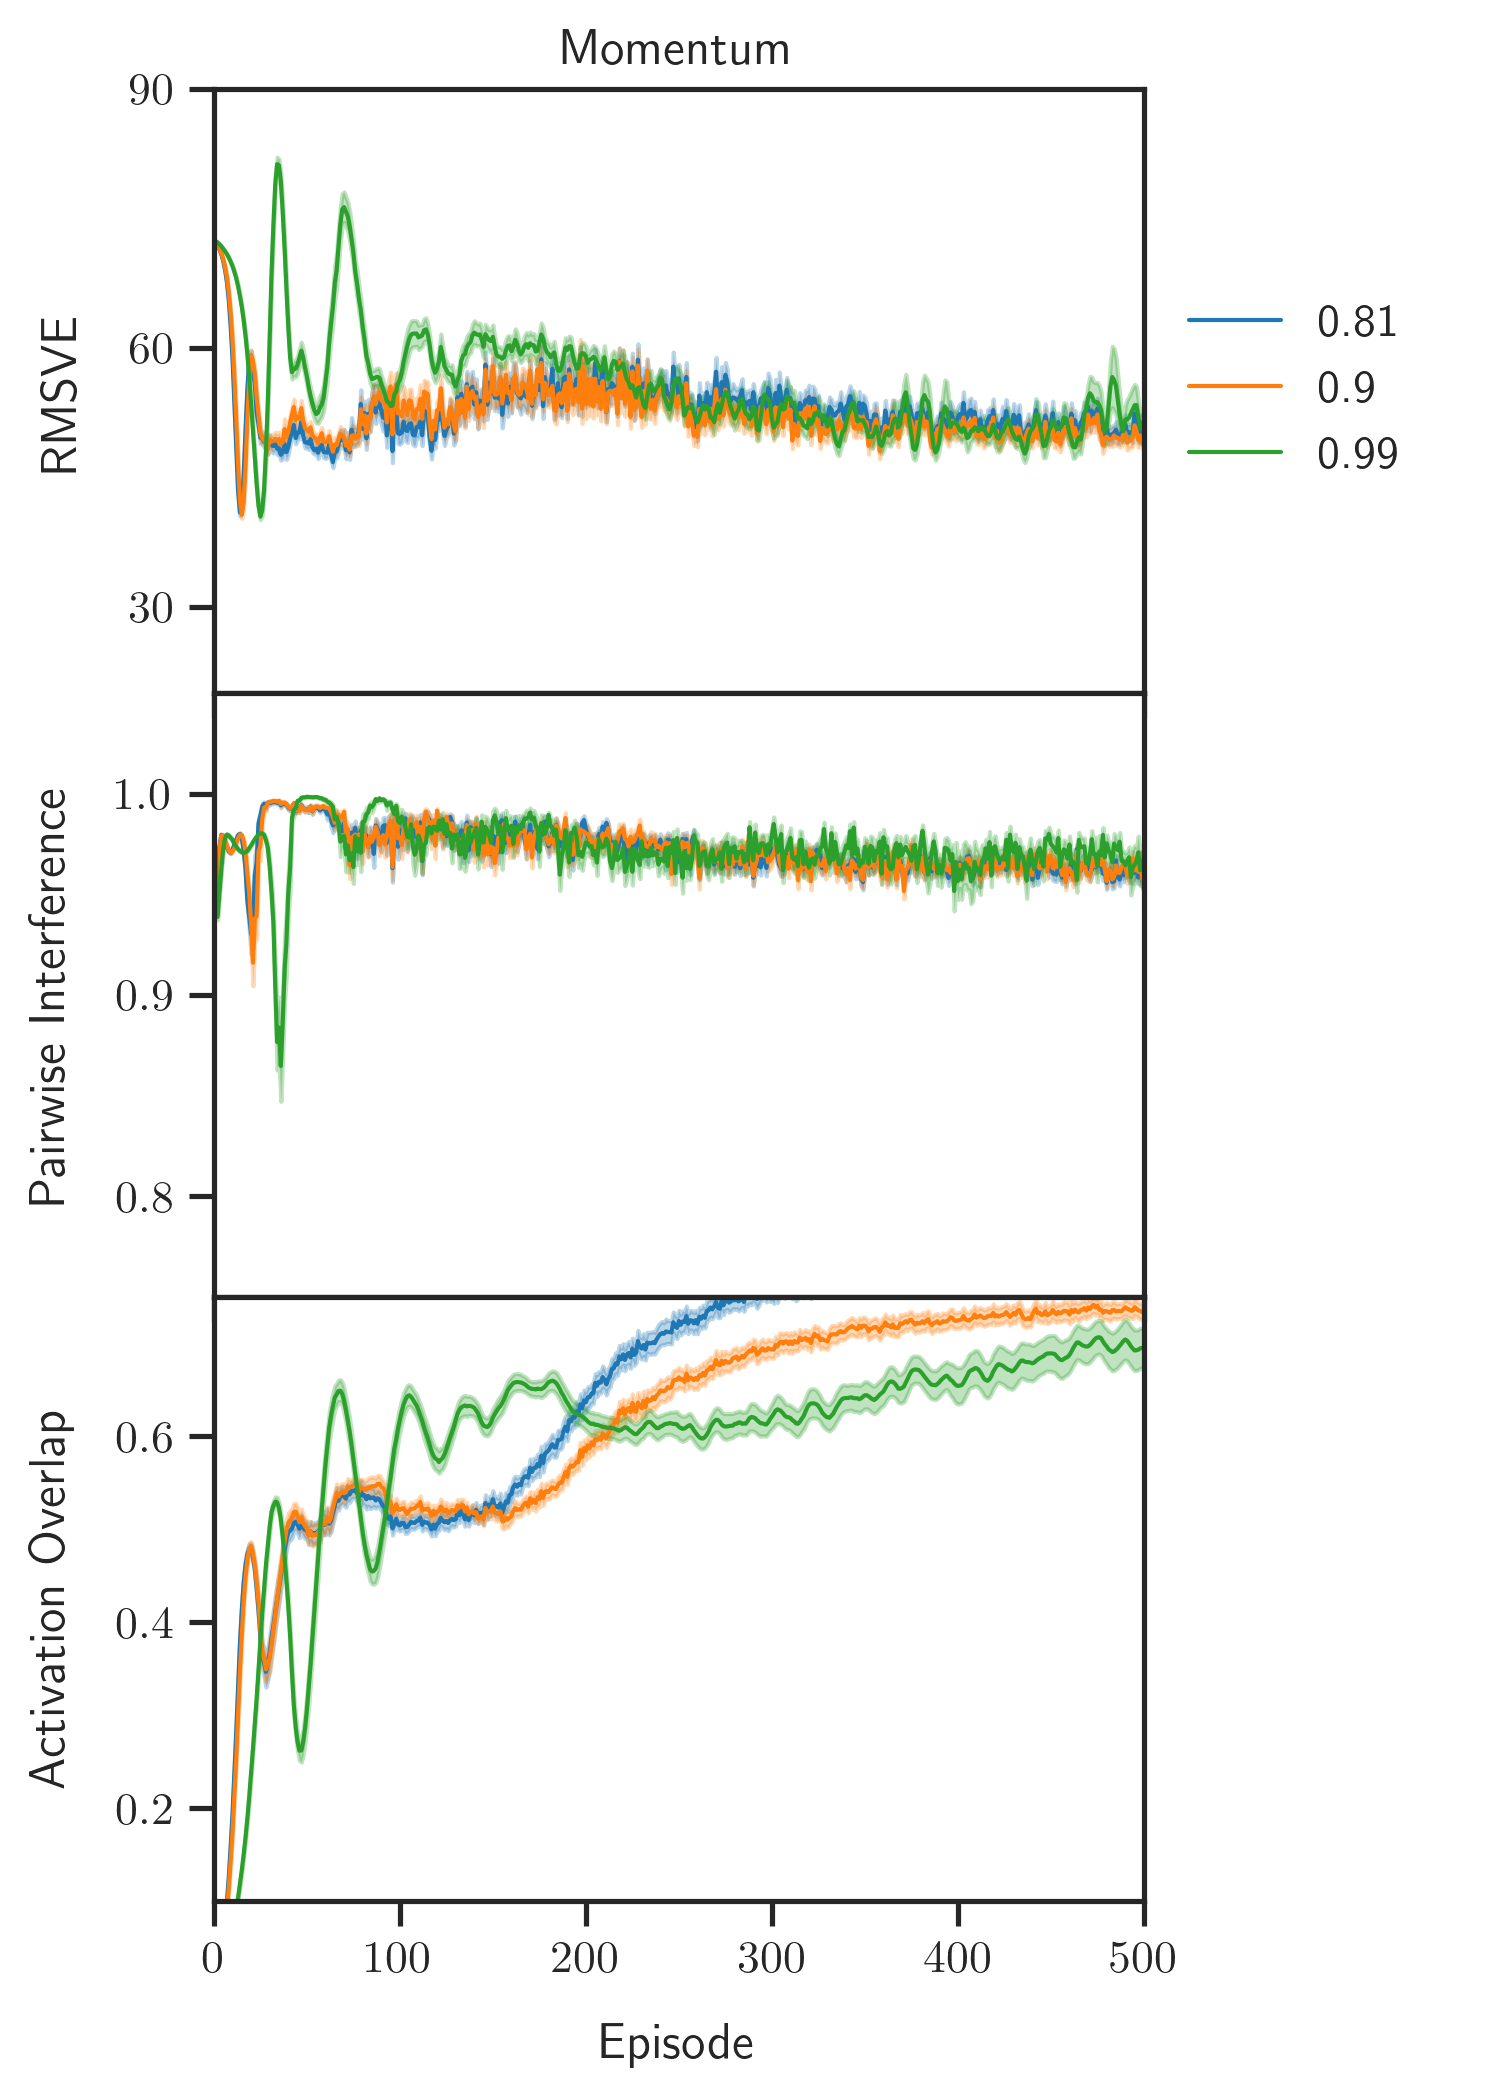

In [5]:
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('Momentum')
ax1.set_ylabel('RMSVE', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax2.set_ylim(0.75, 1.05)
ax2.set_yticks([0.8, 0.9, 1.0])
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_ylim(0.1, 0.75)
ax3.set_yticks([0.2, 0.4, 0.6])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.20, 0.765), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_mountain_car_momentum.pdf', bbox_inches='tight')

## Rho Sensitivity

In [6]:
data = load_data(['experiment_2_mountain_car_train.json'])
to_delete = list()
for i, entry in enumerate(data):
    if entry['optimizer'] != 'rms':
        to_delete.append(i)
    else:
        entry['optimizer'] = entry['rho']
for i in reversed(to_delete):
    del data[i]
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,...,auc_mean,auc_stderr,mean_accuracy_mean,mean_accuracy_stderr,final_accuracy_mean,final_accuracy_stderr,mean_activation_overlap_mean,mean_activation_overlap_stderr,mean_pairwise_interference_mean,mean_pairwise_interference_stderr
0,neural_network,None,None,None,TD,0.000031,None,0.90,0.90,1,...,26014.749646,21.451114,51.925648,0.042817,51.308026,0.391554,0.396546,0.003287,0.980340,0.000160
1,neural_network,None,None,None,TD,0.000043,None,0.99,0.99,1,...,24541.927570,18.275734,48.985883,0.036479,49.554611,0.380479,0.418061,0.003342,0.967114,0.000499
2,neural_network,None,None,None,TD,0.000031,None,0.81,0.81,1,...,27189.534930,40.440940,54.270529,0.080720,67.245475,0.593712,0.421416,0.003569,0.982133,0.000132


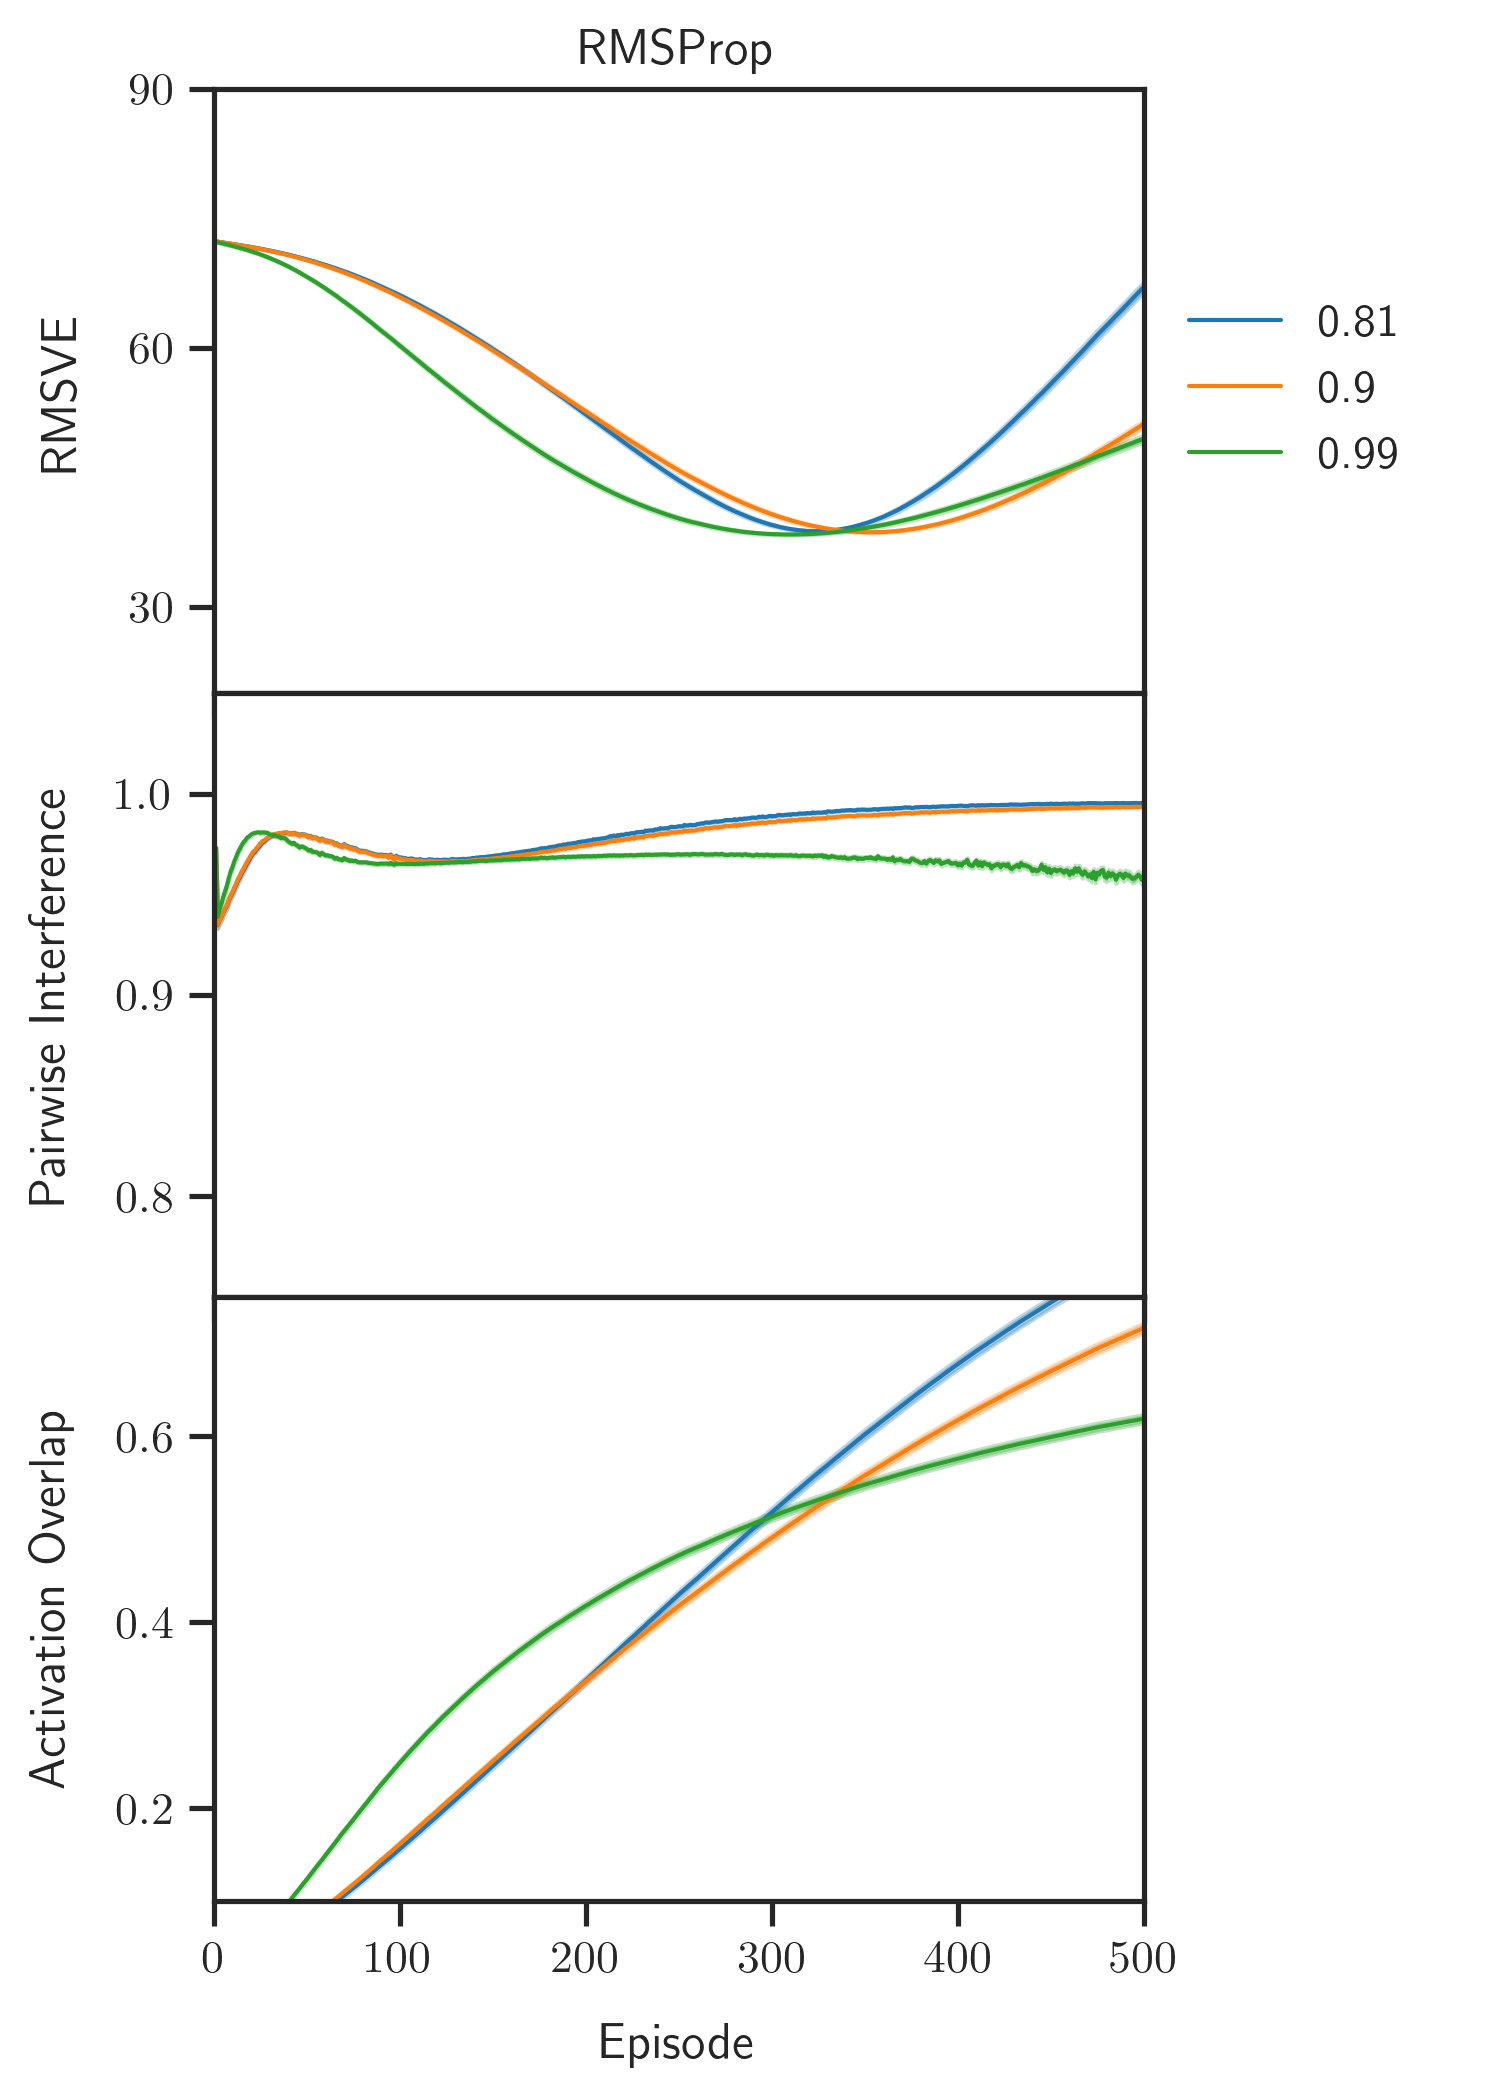

In [7]:
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('RMSProp')
ax1.set_ylabel('RMSVE', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax2.set_ylim(0.75, 1.05)
ax2.set_yticks([0.8, 0.9, 1.0])
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_ylim(0.1, 0.75)
ax3.set_yticks([0.2, 0.4, 0.6])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.20, 0.765), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_mountain_car_rho.pdf', bbox_inches='tight')

## Learning Rate Sensitivity

In [8]:
data = load_data(['experiment_2_mountain_car_train.json'])
summary = get_summary(data)
lr_comparison = dict()
for optimizer in set(summary['optimizer'].unique()) - {'constant'}:
    lr_comparison[optimizer] = summary[summary['optimizer'] == optimizer].sort_values('lr')
lr_comparison['momentum'] = lr_comparison['momentum'][lr_comparison['momentum']['momentum'] == 0.81]
lr_comparison['rms'] = lr_comparison['rms'][lr_comparison['rms']['rho'] == 0.99]

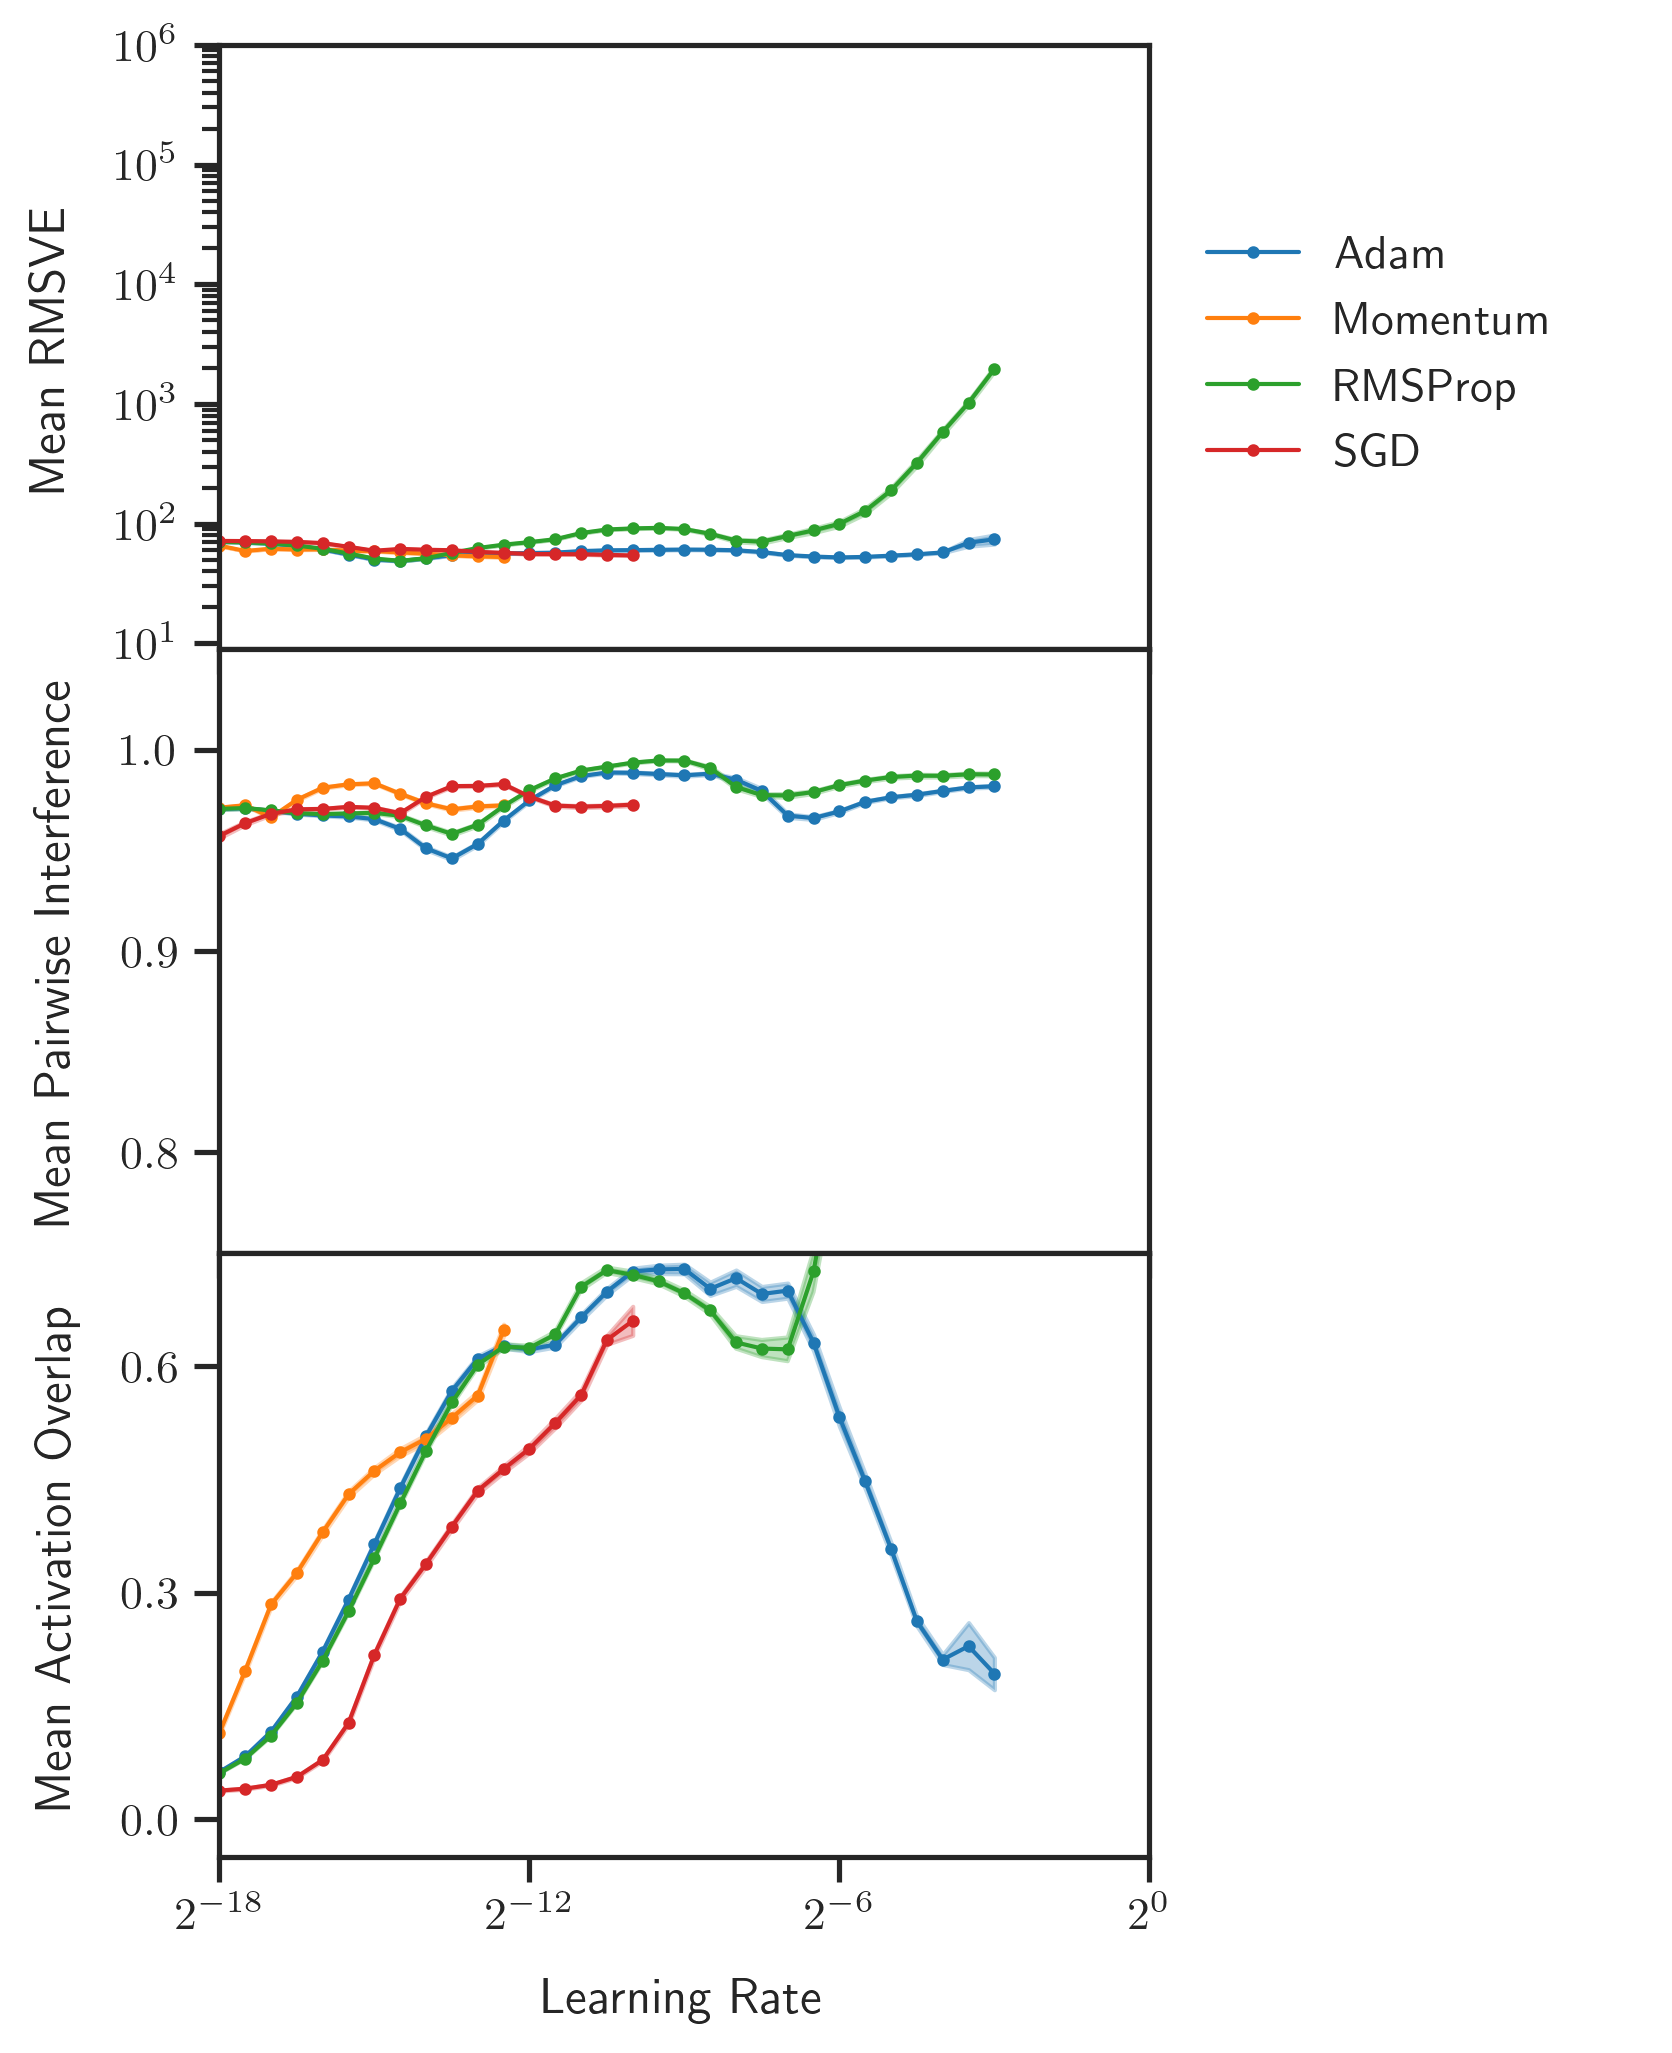

In [9]:
colors = sns.color_palette(n_colors=len(lr_comparison.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: x[0]
for i, (optimizer, value) in enumerate(sorted(lr_comparison.items(), key=sort_key)):
    value = value[value['final_accuracy_mean'].notnull()]
    y1 = value['mean_accuracy_mean']
    y1err = value['mean_accuracy_stderr']
    x = value['lr']
    ax1.plot(
        x,
        y1,
        '-o',
        label=optimizer_nice_names[optimizer],
        markersize=2,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['mean_pairwise_interference_mean']
        y2err = value['mean_pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            '-o',
            linewidth=1,
            markersize=2,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['mean_activation_overlap_mean']
        y3err = value['mean_activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            '-o',
            linewidth=1,
            markersize=2,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_xscale('log', basex=2)
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax1.set_ylim(10 ** 1 - 0.99, 10 ** 6)
ax1.set_yscale('log')
ax2.set_ylabel('Mean Pairwise Interference', labelpad=10)
ax2.set_ylim(0.75, 1.05)
ax2.set_yticks([0.8, 0.9, 1.0])
ax3.set_ylabel('Mean Activation Overlap', labelpad=10)
ax3.set_ylim(- 0.05, 0.75)
ax3.set_yticks([0.0, 0.3, 0.6])
ax3.set_xlim(2 ** (-18), 2 ** 0)
ax3.set_xticks([2 ** (-18), 2 ** (-12), 2 ** (-6), 2 ** 0])
ax3.set_xlabel('Learning Rate', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.33, 0.775), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_mountain_car_lr.pdf', bbox_inches='tight')

# Experiment 2 Test

In [10]:
data = load_data(['experiment_2_mountain_car_test.json'])
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

TypeError: cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>

## H12

In [ ]:
constant = [item['final_accuracy'] for item in best_by_optimizer['constant']]
sgd = [item['final_accuracy'] for item in best_by_optimizer['sgd']]
print('Constant: {0:.4f}+-{1:.4f}\nSGD: {2:12.4f}+-{3:.4f}'.format(
    np.mean(constant),
    np.std(constant) / np.sqrt(len(constant)),
    np.mean(sgd),
    np.std(sgd) / np.sqrt(len(sgd))))
print()
h12_t, h12_p = st.ttest_ind(constant, sgd)
print('H12: {} with p = {}'.format(
    'Reject' if (h12_p < 0.05 / 18) else 'Fail to Reject', h12_p))

## H17

In [ ]:
mean_activation_overlap = dict()
for optimizer in list(set(best_by_optimizer.keys()) - {'constant'}):
    mean_activation_overlap[optimizer] = list()
    for i in range(len(best_by_optimizer[optimizer])):
        values = best_by_optimizer[optimizer][i]['activation_overlap']
        mean_activation_overlap[optimizer].append(np.mean(values))
for k,v in mean_activation_overlap.items():
    print('{0}: {1:.4f}+-{2:.4f}'.format(
        optimizer_nice_names[k],
        np.mean(v),
        np.std(v) / np.sqrt(len(v))))
print()
h17_t, h17_p = st.f_oneway(* mean_activation_overlap.values())
print('H17: {} with p = {}'.format(
    'Reject' if (h17_p < 0.05 / 18) else 'Fail to Reject', h17_p))
print()
df = {'optimizer': list(), 'mean_activation_overlap': list()}
for k, v in mean_activation_overlap.items():
    df['mean_activation_overlap'] += v
    df['optimizer'] += [k] * len(v)
df = pd.DataFrame(df)
h17_tukey = str(MultiComparison(df['mean_activation_overlap'], df['optimizer']).tukeyhsd(0.05 / 18).summary())
print(h17_tukey)

## H18

In [ ]:
mean_pairwise_interference = dict()
for optimizer in list(set(best_by_optimizer.keys()) - {'constant'}):
    mean_pairwise_interference[optimizer] = list()
    for i in range(len(best_by_optimizer[optimizer])):
        values = best_by_optimizer[optimizer][i]['pairwise_interference']
        mean_pairwise_interference[optimizer].append(np.mean(values))
for k,v in mean_pairwise_interference.items():
    print('{0}: {1:.4f}+-{2:.4f}'.format(
        optimizer_nice_names[k],
        np.mean(v),
        np.std(v) / np.sqrt(len(v))))
print()
h18_t, h18_p = st.f_oneway(* mean_pairwise_interference.values())
print('H18: {} with p = {}'.format(
    'Reject' if (h18_p < 0.05 / 18) else 'Fail to Reject', h18_p))
print()
df = {'optimizer': list(), 'mean_pairwise_interference': list()}
for k, v in mean_pairwise_interference.items():
    df['mean_pairwise_interference'] += v
    df['optimizer'] += [k] * len(v)
df = pd.DataFrame(df)
h18_tukey = str(MultiComparison(df['mean_pairwise_interference'], df['optimizer']).tukeyhsd(0.05 / 18).summary())
print(h18_tukey)

## Plotting

In [ ]:
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer_nice_names[optimizer],
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_ylabel('RMSVE', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax2.set_ylim(0.75, 1.05)
ax2.set_yticks([0.8, 0.9, 1.0])
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_ylim(0.1, 0.75)
ax3.set_yticks([0.2, 0.4, 0.6])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.33, 0.79), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_mountain_car_optimizers.pdf', bbox_inches='tight')

In [ ]:
mean_activation_overlap = dict()
for optimizer in list(set(best_by_optimizer.keys()) - {'constant'}):
    mean_activation_overlap[optimizer] = list()
    for i in range(len(best_by_optimizer[optimizer])):
        values = best_by_optimizer[optimizer][i]['activation_overlap']
        mean_activation_overlap[optimizer].append(np.mean(values))

mean_pairwise_interference = dict()
for optimizer in list(set(best_by_optimizer.keys()) - {'constant'}):
    mean_pairwise_interference[optimizer] = list()
    for i in range(len(best_by_optimizer[optimizer])):
        values = best_by_optimizer[optimizer][i]['pairwise_interference']
        mean_pairwise_interference[optimizer].append(np.mean(values))

text = ''
text += '|-----------|-------------------------|----------------------------|\n'
text += '| Optimizer | Mean Activation Overlap | Mean Pairwise Interference |\n'
text += '|-----------|-------------------------|----------------------------|\n'
for optimizer in sorted(list(mean_activation_overlap.keys())):
    text += '| {0:>9} |     {1:>6.4f}+-{2:<6.4f}      |       {3:>6.4f}+-{4:<6.4f}       |\n'.format(
        optimizer_nice_names[optimizer],
        np.mean(mean_activation_overlap[optimizer]),
        np.std(mean_activation_overlap[optimizer]) / np.sqrt(len(mean_activation_overlap[optimizer])),
        np.mean(mean_pairwise_interference[optimizer]),
        np.std(mean_pairwise_interference[optimizer]) / np.sqrt(len(mean_pairwise_interference[optimizer])))
text += '|-----------|-------------------------|----------------------------|\n'
with open('experiment_2_mountain_car_mean_metrics.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)